<a href="https://colab.research.google.com/github/mobndash/Exploratory-Data-Analysis-EDA-Techniques/blob/main/EDA_Transformers_and_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
df = pd.read_csv("/content/covid_toy.csv")

In [ ]:
df.head()

,age,gender,fever,cough,city,has_covid
0,60,Male,103.0,Mild,Kolkata,No
1,27,Male,100.0,Mild,Delhi,Yes
2,42,Male,101.0,Mild,Delhi,No
3,31,Female,98.0,Mild,Kolkata,No
4,65,Female,101.0,Mild,Mumbai,No




# **> Column Transformer**
A ColumnTransformer in scikit-learn is a class that enables the application of different data transformations to different subsets of columns within a dataset. This is particularly useful when dealing with heterogeneous data, where various columns (e.g., numerical, categorical) require different preprocessing steps.



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns = ["has_covid"])
y = df["has_covid"]

Here, gender column needs One Hot Encoding or K-1 Hot Encoding:::::cough column needs Ordinal Encoding :::::: city column needs One Hot or K-1 Encoding. So we apply all these using Column Transformer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape, X_test.shape

((80, 5), (20, 5))

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
# passthrough = do nothing, else can be dropped
transformer = ColumnTransformer(transformers = [
    ("tnf1", SimpleImputer(), ["fever"]),
    ("tnf2", OrdinalEncoder(categories = [["Mild", "Strong"]]), ["cough"]),
    ("tnf3", OneHotEncoder(sparse_output= False, drop = "first"), ["gender", "city"])
], remainder = "passthrough")

In [ ]:
transformer.fit_transform(X_train).shape

(80, 7)

In [ ]:
transformer.transform(X_test).shape

(20, 7)



## **> Pipeline**



Steps : For column Age and Embarked

*   Step 1 : Impute missing values for Age, send output to Step 2
*   Step 2 : Apply One Hot Encoding for Age and Embarked, send output to Step 3


*   Step 3 : Scale the columns, send output to Step 4

*   Step 4 : Feature Selection, send output to Step 5

*   Step 5 : Train the model

* The output at each stage is numpy array and NOT df, so represnt column by index e.g Incorrect : ["Age"] ||   Correct : [2]




In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin"], inplace = True)

In [ ]:
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


In [ ]:
X = df.drop(columns = ["Survived"])
y = df["Survived"]

In [ ]:
# Column groups
numeric_cols = ["Age", "Fare"]
categorical_cols = ["Sex", "Embarked"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5000,S
733,2,male,23.0,0,0,13.0000,S
382,3,male,32.0,0,0,7.9250,S
704,3,male,26.0,1,0,7.8542,S
813,3,female,6.0,4,2,31.2750,S


In [ ]:
# Column Transformer for Simple Imputer
coltra_1 = ColumnTransformer([
    ("age_imputer", SimpleImputer(strategy="mean"), [2]),
    ("embarked_imputer", SimpleImputer(strategy="most_frequent"), [6])
], remainder="passthrough")

In [ ]:
# Column Transformer for One Hot Encoding
coltra_2 = ColumnTransformer([
    ("ohe_sex_embarked", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), [1, 6])
], remainder="passthrough")

In [ ]:
# Column Transformer for Scaling
coltra_3 = ColumnTransformer([
    ("scaling", MinMaxScaler(), [0, 1, 2, 3, 4])  # Only the numeric columns
], remainder="passthrough")

In [ ]:
# Column Transformer for best feature selection and select top 5 features
coltra_4 = SelectKBest(score_func=chi2, k=8)


In [ ]:
# Train the model
coltra_5 = DecisionTreeClassifier()




> Create a pipeline



In [ ]:
pipe = Pipeline([
    ("coltra_1", coltra_1),
    ("coltra_2", coltra_2),
    ("coltra_3", coltra_3),
    ("coltra_4", coltra_4),
    ("coltra_5", coltra_5)
])



> Pipeline vs Make Pipeline


---


pipeline requires naming of steps, make_pipeline does not


---

Same, column_transformer vs make_column_transformer



In [ ]:
pipe_sequential = make_pipeline(coltra_1, coltra_2, coltra_3, coltra_4, coltra_5)




> OR structurally use below



In [ ]:
preprocessor = ColumnTransformer([
    # Handle ALL numeric features with comprehensive imputation
    ("numeric", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),  # Impute ALL numeric columns
        ("scaler", MinMaxScaler())
    ]), [0, 2, 3, 4, 5]),  # Pclass, Age, SibSp, Parch, Fare

    # Handle ALL categorical features with comprehensive imputation
    ("categorical", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute ALL categorical columns
        ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ]), [1, 6])  # Sex, Embarked
], remainder="drop")

In [ ]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=chi2, k=8)),
    ("model", DecisionTreeClassifier())
])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 2, 3, 4, 5]),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [1, 6])])),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x7df9e2e54680>)),
                ('model', DecisionTreeClassifier())])



> Since, we are training thr model we called pipe.fit so that predict can be called later. If only preprocessing, fit_transform with no model calling



In [ ]:
pipe.named_steps

{'preprocessor': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', MinMaxScaler())]),
                                  [0, 2, 3, 4, 5]),
                                 ('categorical',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  [1, 6])]),
 'feature_selection': SelectKBest(k=8, score_func=<function chi2 at 0x7df9e2e54680>),
 'model': DecisionTreeClassifier()}

In [ ]:
pipe.named_steps["preprocessor"].transformers_[1][1]

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy * 100

78.77094972067039



# **> Cross Validation using Pipeline**



In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
print(cross_val_score(pipe, X_train, y_train, cv = 5, scoring = "accuracy").mean() * 100)

79.22584457795725




# **> GridSearchCV**



In [ ]:
params = {
    "model__max_depth" : [1, 2, 3, 4, 5, None]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = GridSearchCV(pipe, params, cv = 5, scoring = "accuracy")
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5]),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         [1,
                                                                          6])])),
                                       ('feature_selection',
                                        SelectKBest(k=8,
                                                    score_func=<function chi2 at 0x7df9e2e54680>)),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': [1, 2, 3, 4, 5, None]},
             scoring='accuracy')

In [ ]:
print(grid.best_score_)

0.8033093666896484




> Function Transformers


> Goal : To change the distribution of the data from anything to Normal or close to Normal. Linear Regression specially needs it. For DT, it does not matter

> Log Transformation



> Reciprocal Transformation



> Power Transformation



> Box-Cox Transformation












In [ ]:
print("Best CV score (mean over inner folds):", grid.best_score_)
print("Best params:", grid.best_params_)
print("Best estimator:", grid.best_estimator_)

Best CV score (mean over inner folds): 0.8033093666896484
Best params: {'model__max_depth': 3}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 2, 3, 4, 5]),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEn

In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


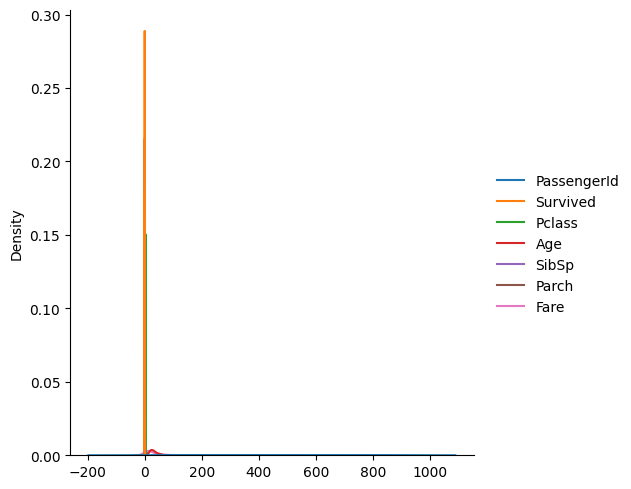

In [ ]:
sns.displot(df, kind = "kde")

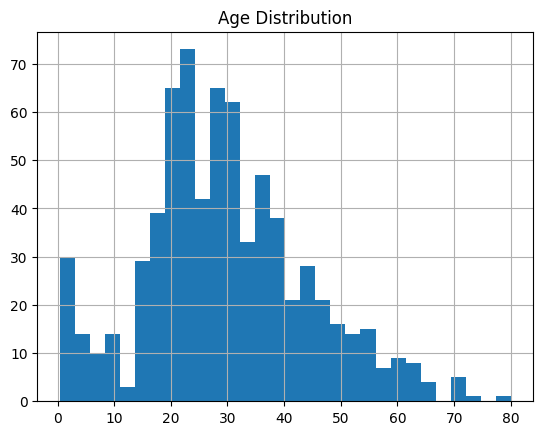

In [ ]:
df['Age'].hist(bins=30)
plt.title("Age Distribution")
plt.show()

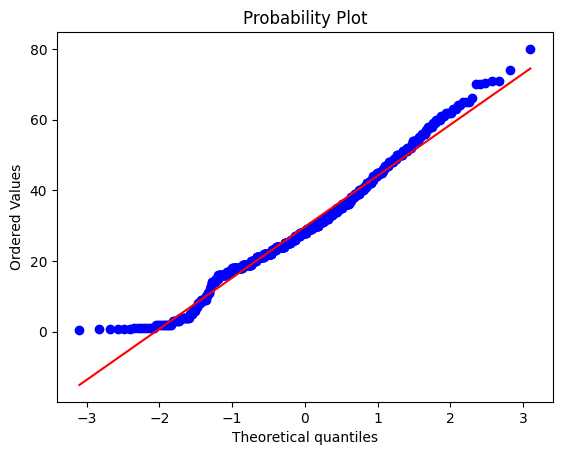

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Also called Quantile - Quantile (QQ) plot
stats.probplot(df['Age'].dropna(), dist="norm", plot=plt)
plt.show()


In [ ]:
def validate_distribution(df, dist="norm"):
    for col in df.select_dtypes(include=["number"]).columns:  # only numeric
        data = df[col].dropna()

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram + KDE
        sns.histplot(data, kde=True, ax=axes[0], bins=30, color="skyblue")
        axes[0].set_title(f"{col} - Distribution Plot")

        # Q-Q plot
        stats.probplot(data, dist=dist, plot=axes[1])
        axes[1].set_title(f"{col} - Q-Q Plot vs {dist.title()}")

        plt.tight_layout()
        plt.show()

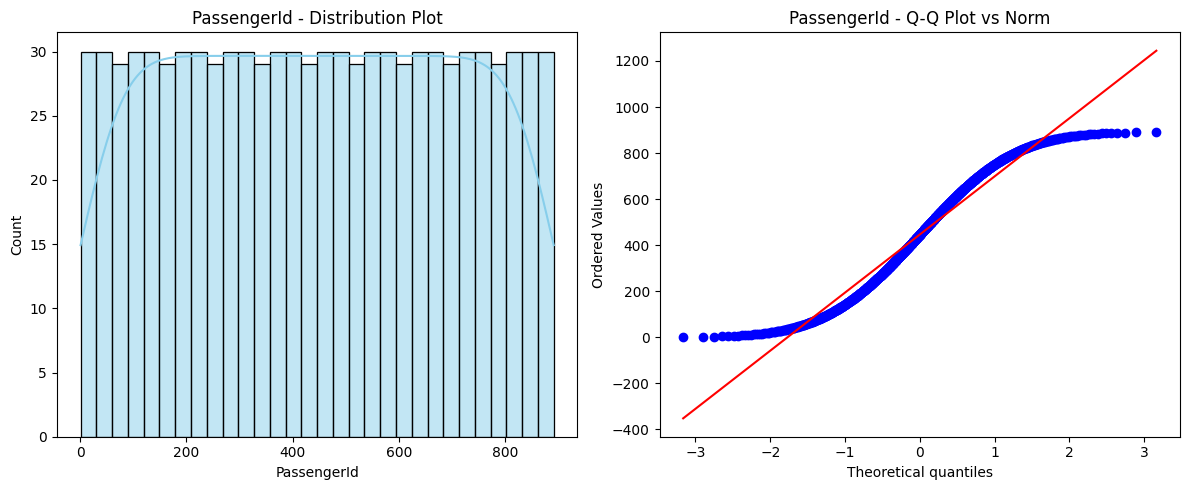

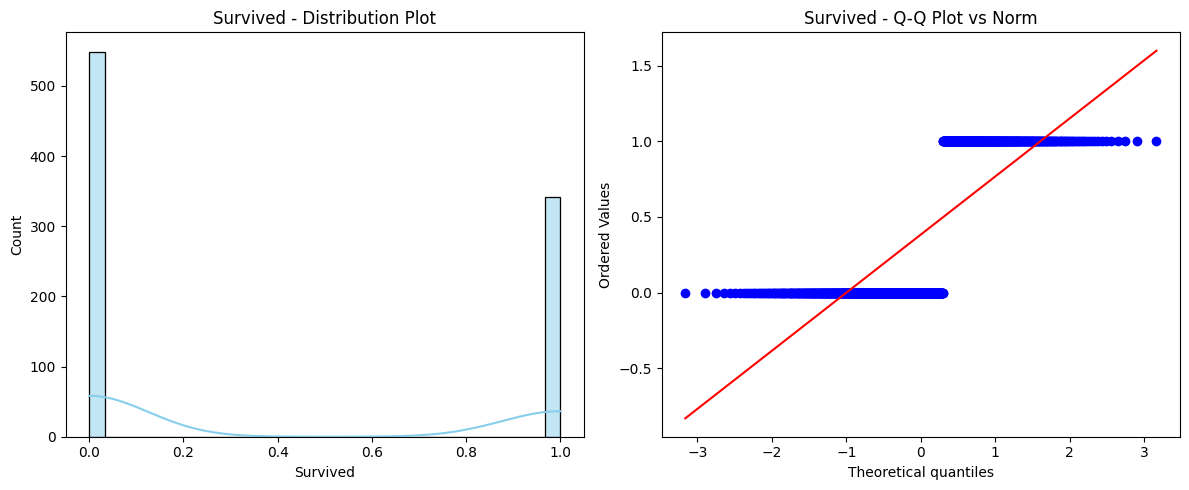

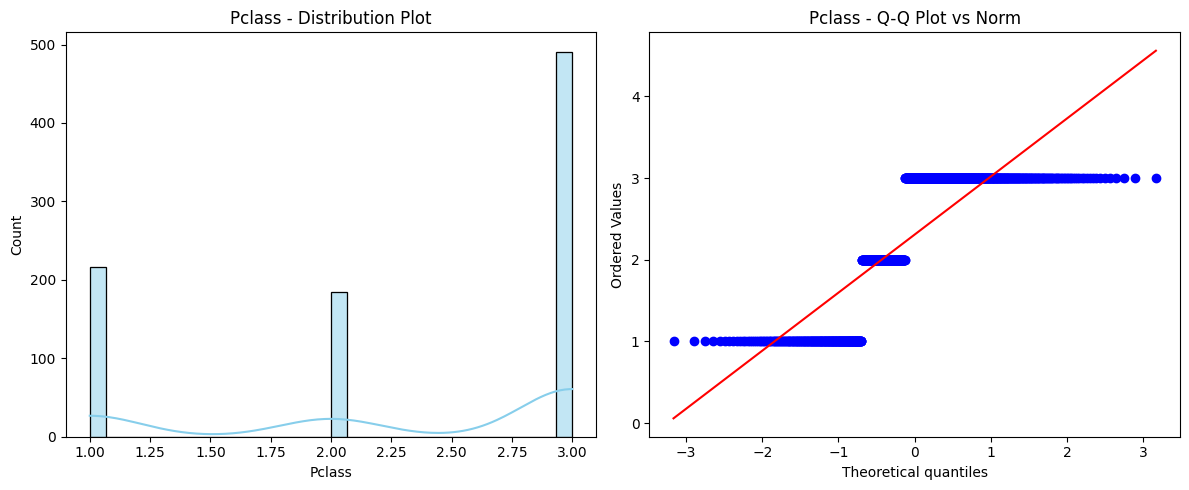

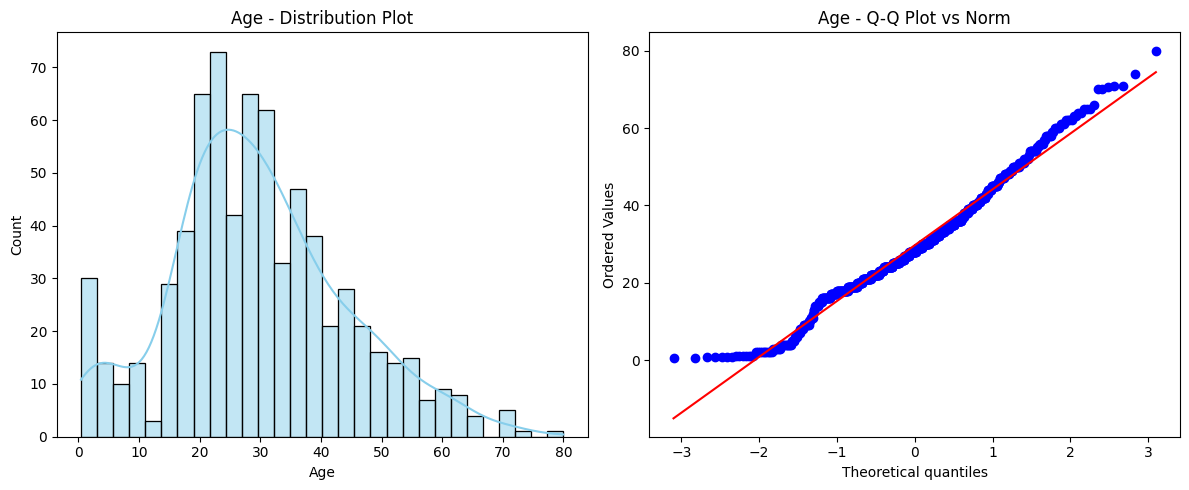

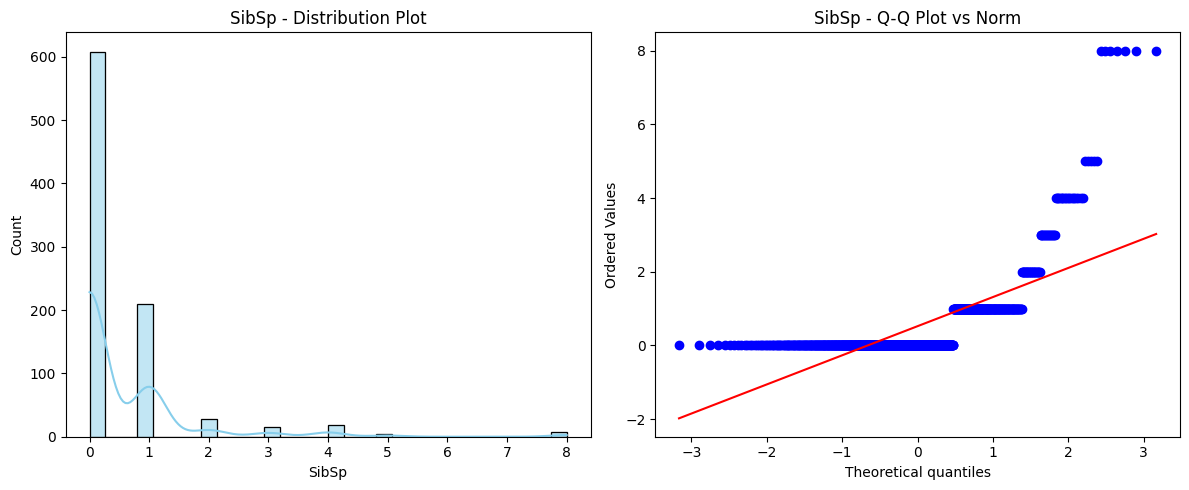

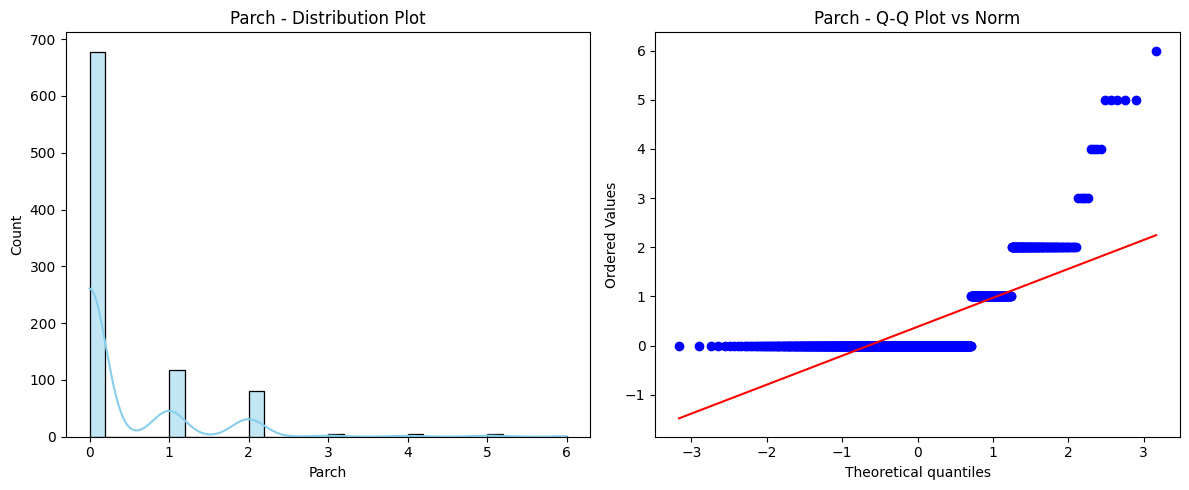

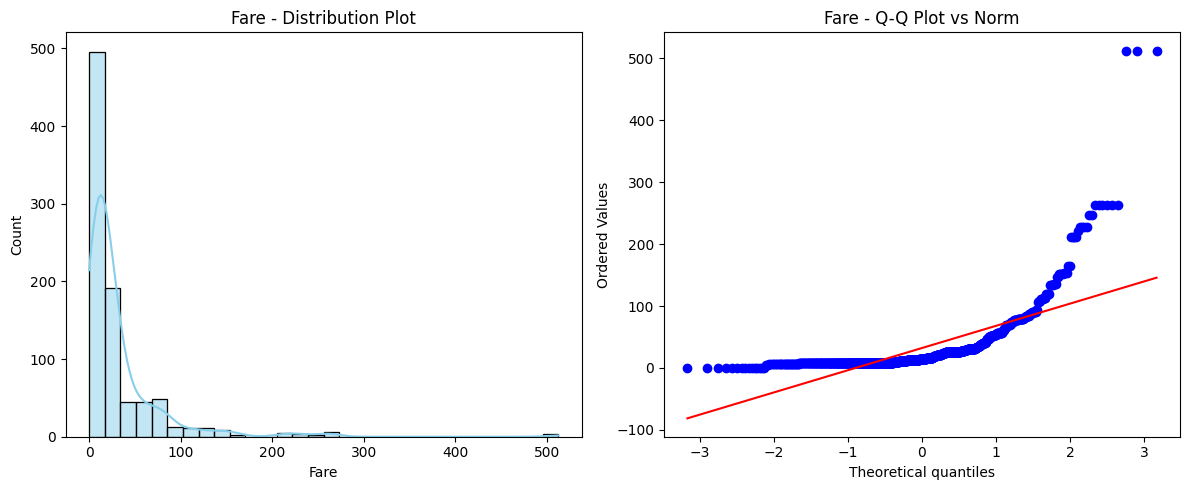

In [ ]:
validate_distribution(df)



> Log Transform : Works on Right Skewed data and transforms to Normal. Does not work on negative values, Log transform brings the big numbers to small. E.g Fare is Right Skewed



> Square Transform : Works on Left Skewed data and transforms to Normal




In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_csv("/content/train.csv", usecols = ["Age", "Fare", "Survived"])

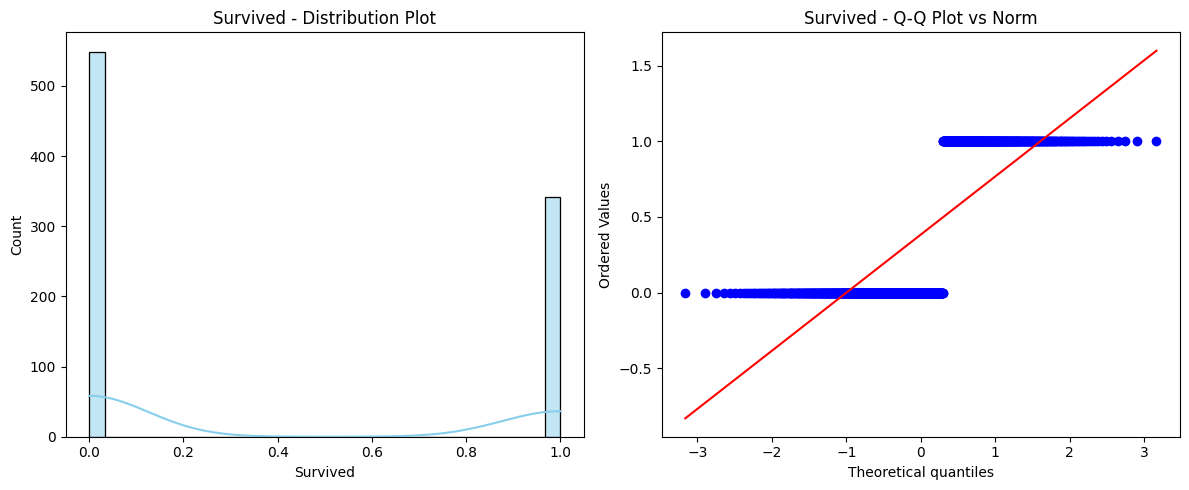

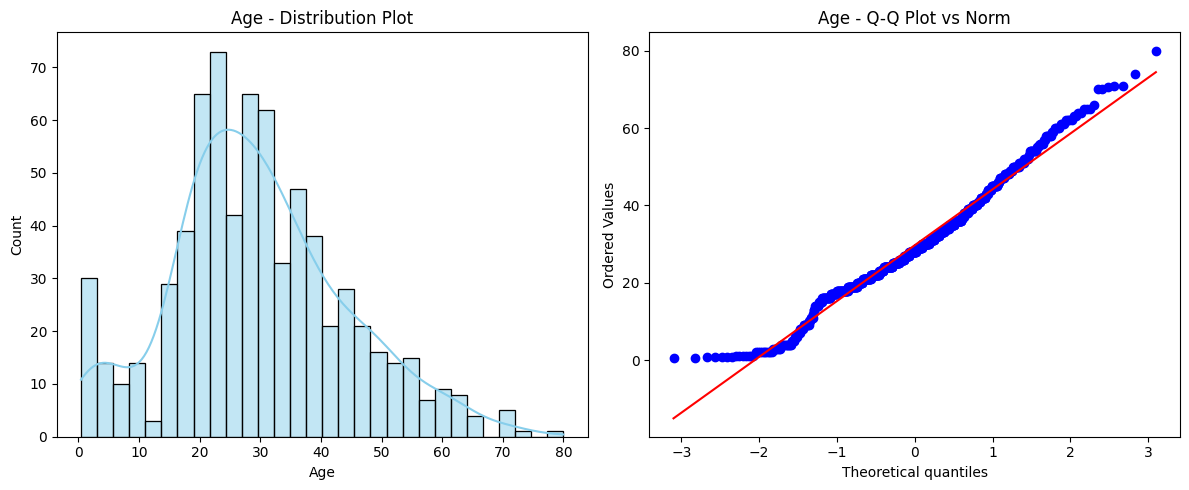

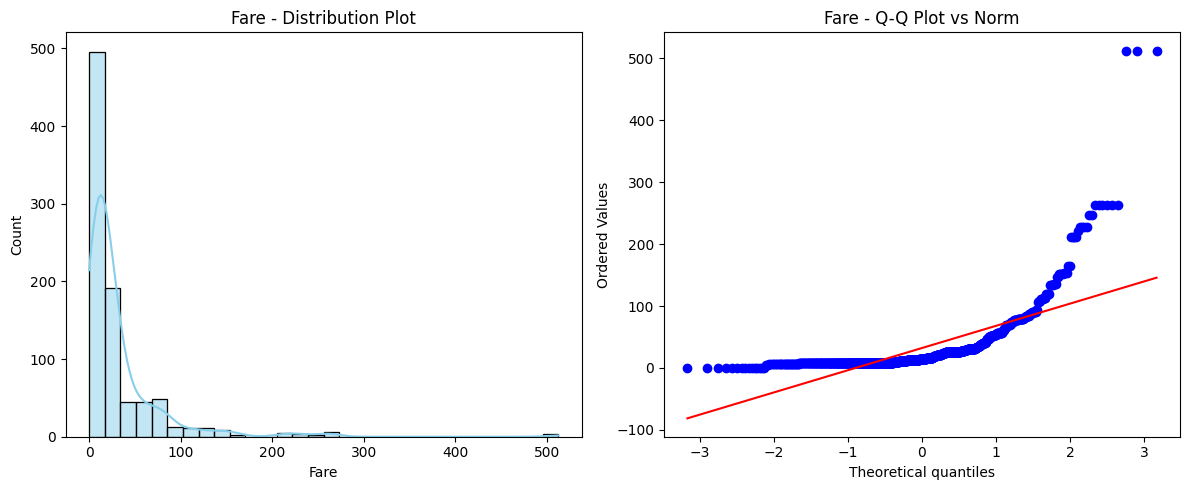

In [ ]:
def validate_distribution(df, dist="norm"):
    for col in df.select_dtypes(include=["number"]).columns:  # only numeric
        data = df[col].dropna()

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram + KDE
        sns.histplot(data, kde=True, ax=axes[0], bins=30, color="skyblue")
        axes[0].set_title(f"{col} - Distribution Plot")

        # Q-Q plot
        stats.probplot(data, dist=dist, plot=axes[1])
        axes[1].set_title(f"{col} - Q-Q Plot vs {dist.title()}")

        plt.tight_layout()
        plt.show()

validate_distribution(df)

In [ ]:
# Applying log transform on Fare since it is right skewed

fun_trans = FunctionTransformer(func = np.log1p)
df["Fare_log_transformed"] = fun_trans.fit_transform(df["Fare"])
df["Age_log_transformed"] = fun_trans.fit_transform(df["Age"])

In [ ]:
# Applying square transform on Age

def square_func(X):
    return np.square(X)

func_trans_sq = FunctionTransformer(func = square_func)
df["Age_square_transformed"] = func_trans_sq.fit_transform(df["Age"])

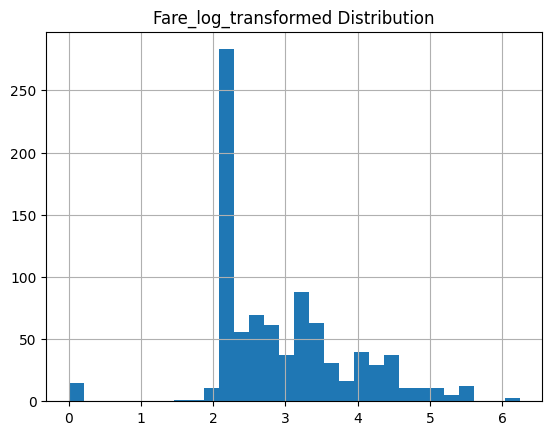

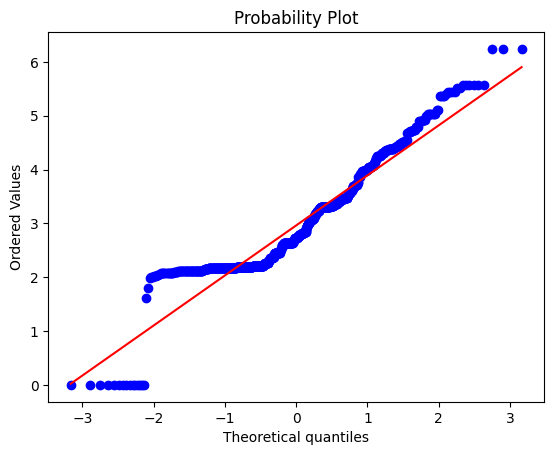

In [ ]:
df['Fare_log_transformed'].hist(bins=30)
plt.title("Fare_log_transformed Distribution")
plt.show()

# Q-Q plot
stats.probplot(df['Fare_log_transformed'].dropna(), dist="norm", plot=plt)
plt.show()

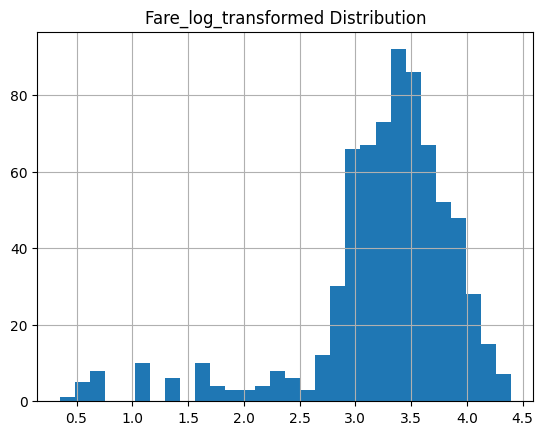

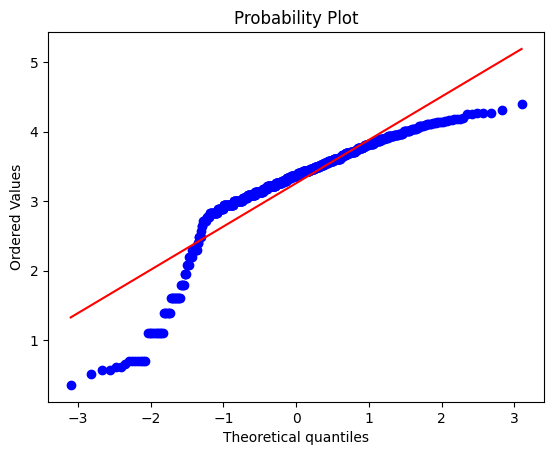

In [ ]:
# Applying log transform on Age, destroyed its distribution. because Age is almost correctly Normal
df['Age_log_transformed'].hist(bins=30)
plt.title("Fare_log_transformed Distribution")
plt.show()

# Q-Q plot
stats.probplot(df['Age_log_transformed'].dropna(), dist="norm", plot=plt)
plt.show()




# **> Power Transformation works better than Function Transformers**


> Box - Cox Transformation :
arameter λ (lambda) controls how data is transformed.

λ=1 → data unchanged.

λ=0 → natural log transformation.

✅ Requirement: all input values must be positive (>0).

>  Yeo - Johnson Transformation :
✅ Works for positive, zero, and negative values.



In [ ]:
from sklearn.preprocessing import PowerTransformer

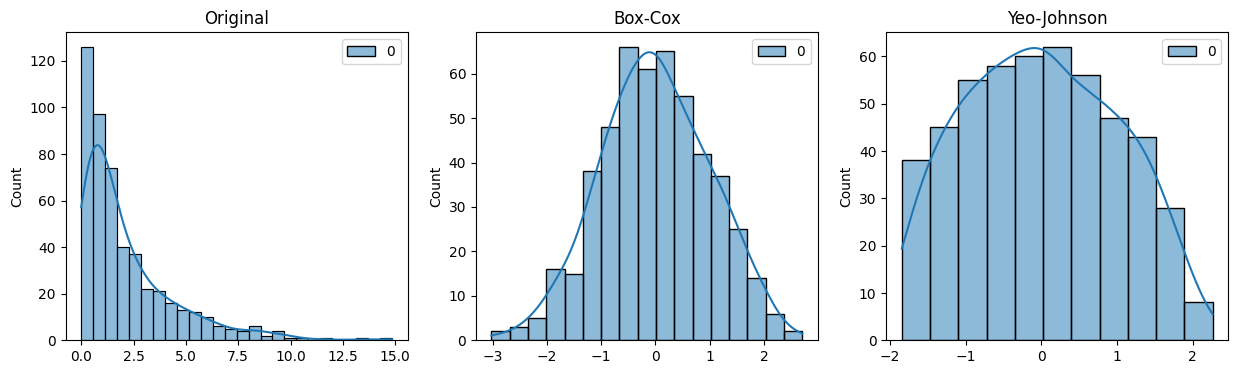

(500, 1)


In [ ]:
data = np.random.exponential(scale=2, size=500).reshape(-1, 1)

# Apply transformations
pt_bc = PowerTransformer(method="box-cox")
data_bc = pt_bc.fit_transform(data)

pt_yj = PowerTransformer(method="yeo-johnson")
data_yj = pt_yj.fit_transform(data)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(data, kde=True, ax=axes[0]); axes[0].set_title("Original")
sns.histplot(data_bc, kde=True, ax=axes[1]); axes[1].set_title("Box-Cox")
sns.histplot(data_yj, kde=True, ax=axes[2]); axes[2].set_title("Yeo-Johnson")
plt.show()

print(data.shape)